In [ ]:
#|default_exp images

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#|export

import copy
import csv
import json
import os
import random
from collections.abc import Generator
from dataclasses import dataclass, field
from glob import glob
from pathlib import Path

import numpy as np
import polars as pl
from PIL import Image
from tqdm.auto import tqdm

from clip_plot.utils import FILE_NAME, timestamp


# Process images

In [ ]:
#| export

def load_image(image_path:str, format:str="RGB")->Image.Image:
    '''load an image and convert to desired format'''
    return Image.open(image_path).convert(format)

## Resize functions

In [ ]:
#| hide

testimage = Path("../tests/smithsonian_butterflies_10/jpgs/3fee89f9b-ba5c-4f2e-8532-6e390e2cf0c9.jpg")
# testimage = Path("../datasets/internet-seismic/SLIM_figure-1d.jpg")
# testimage = Path("../datasets/internet-seismic/SLIM_wMult.jpg")

im = Image.open(testimage)

In [ ]:
#| export

def resize_to_max_side(img: Image.Image, maxlen:int=128):
    '''
    resize to a maximum side length
    '''
    w, h = img.size
    if w > h:
        # preserve ratio but ensure height is >=1 pixel
        size =  (maxlen, max(1, int(maxlen * h / w)))
    else:
        # preserve ratio but ensure width is >=1 pixel
        size =  (max(1, int(maxlen * w / h)), maxlen)
    return img.resize(size, reducing_gap=2.0)

In [ ]:
#| export

def resize_to_height(img: Image.Image, height:int=128):
    '''
    resize to an exact height
    '''
    w, h = img.size
    if (w / h * height) < 1:
            resizedwidth = 1
    else:
        resizedwidth = int(w / h * height)
    size= (resizedwidth, height)
    return img.resize(size, reducing_gap=2.0)

### `autocontrast_preserve_lightness`

Sometimes, a thumbnail looks muddy and can benefit from boosting the contrast

In [ ]:
#| export

def autocontrast(img: Image.Image) -> Image.Image:
    '''autocontrast lifted from keras library --
    added lightness normalization'''
    x = np.asarray(img, dtype=float)
    mean_before = x.mean()
    ## autocontrast from Keras
    x = x - np.min(x)
    x_max = np.max(x)
    if x_max != 0:
        x /= x_max
    x *= 255
    ## return to average lightness of input image
    mean_shift = x.mean() - mean_before
    x = np.clip(x - mean_shift, 0, 255)
    return Image.fromarray(x.astype("uint8"))

(96, 64)


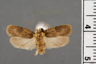

In [ ]:
#| hide
print(resize_to_height(im, 64).size)
autocontrast(resize_to_height(im, 64))

(64, 42)


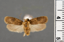

In [ ]:
#| hide
print(resize_to_max_side(im, 64).size)
autocontrast(resize_to_max_side(im, 64))

## Atlases

In [ ]:
#| export

def get_image_paths(images: str | list) -> list[Path]:
    """
    Called once to provide a list of image paths
    """
    if isinstance(images, list):
        image_paths = [Path(im) for im in images]
    elif isinstance(images, str):
        image_paths = [Path(im) for im in glob(images, recursive=True)]

    if len(image_paths) == 0:
        raise FileNotFoundError("Error: No input images were found. Please check your --images glob")
    else:
        return image_paths

## Align metadata

Really this should all just use a dataframe

In [ ]:
#| export

def load_metadata(metadata_paths: list[Path]) -> pl.DataFrame:
    """load metadata from disk into a single dataframe"""
    if metadata_paths[0].suffix.lower() == ".csv":
        return pl.concat((pl.read_csv(loc) for loc in metadata_paths),
                         how="diagonal_relaxed")
    elif metadata_paths[0].suffix.lower() == ".json":
        return pl.concat((pl.read_json(loc) for loc in metadata_paths),
                         how="diagonal_relaxed")

In [ ]:
#| hide
glob_example = "../tests/smithsonian_butterflies_10/meta_data/*.csv"
mpaths = list(Path().glob(glob_example))
df = load_metadata(mpaths)
len(df) == 50

True

In [ ]:
#| export

def get_metadata_list(metadata_paths: list[Path]) -> tuple[list[dict] , list[str]]:
    """Return a list of objects with image metadata.

    Will create 'tags' key if 'category' is in metadata
    but not 'tags'.

    Returns:
        l (List[dict]): List of metadata

    Notes:
        No check for 'filename' is performed

    Todo:
        Think about separating .csv and json functionality.
        Can we use pandas numpy to process csv?
    """
    # handle csv metadata
    metaList = []

    if metadata_paths[0].suffix == ".csv":
        if len(metadata_paths) != 1:
            raise NotImplementedError("Currently hardcoded for a single csv file or multiple json")
        with open(metadata_paths[0]) as f:
            reader = csv.reader(f)
            headers = [i.lower() for i in next(reader)]
            for i in reader:
                metaList.append(
                    {
                        headers[j]: i[j] if len(i) > j and i[j] else ""
                        for j, _ in enumerate(headers)
                    }
                )
    
    # handle json metadata
    else:
        for p in metadata_paths:
            with open(p) as f:
                metaList.append(json.load(f))

    # if the user provided a category but not a tag, use the category as the tag
    for metaDict in metaList:
        if "category" in metaDict and ("tags" in metaDict) is False:
            metaDict.update({"tags": metaDict["category"]})
    return metaList, headers

In [ ]:
#| export

@dataclass
class ValidImage:
    path: Path
    _original: Image.Image | None = None
    _unique_name: str | None = None
    metadata: dict = field(default_factory=dict)

    @property
    def original(self):
        if self._original is None:
            self._original = load_image(self.path.as_posix())
        return self._original

    @property
    def unique_name(self):
        """Save as name when copying image."""
        if self._unique_name is None:
            self._unique_name = self.path.name
        return self._unique_name


    def valid(self, thumbnail_size: int, oblong_ratio: int | float) -> tuple[bool, str]:
        """Validate that image can be opened and loaded correctly.

        Args:
            thumbnail_size (int):
            oblong_ratio (int|float): atlas_size/atlas_row_height ratio

        Returns:
            Tuple[pass,msg]:
                pass (bool): True if passed validation
                msg (str): Reason why validation failed 
        """
        w, h = self.original.size
        # remove images with 0 height or width when resized to lod height
        if (h == 0) or (w == 0):
            return False, f"Skipping {self.path} because it contains 0 height or width"
        # remove images that have 0 height or width when resized
        try:
            _ = resize_to_height(self.original, height=thumbnail_size)
        except ValueError:
            return False, f"Skipping {self.path} because it contains 0 height or width when resized"
        except OSError:
            return False, f"Skipping {self.path} because it could not be resized"
        # remove images that are too wide for the atlas
        if (w / h) > (oblong_ratio):
            return False, f"Skipping {self.path} because its dimensions are oblong"

        return True, ""

## Image Factory

Our goal is to provide an extensible backbone for clip-plot by implementing an agnostic image engine.
Images and their metadata might need to be processed from different sources.  
In addition the fallowing issues must be handled by the image engine:
  - Matching metadata with their images
  - Handling non-unique image names




![image-2.png](attachment:image-2.png)

In [ ]:
#| export

@dataclass
class ImageFactory:
    """
    Access images,
    including compiling metadata.

    Factory is responsible for:
        - Compiling image files and their metadata
        - Filtering and validating images
        - Naming image output names
        - Providing property values

    Image factory needs to be able to provide an Image instance
        - The image instance needs to be have its metadata (if applicable)
    """
    image_paths: list[Path]
    data_dir: Path
    metadata_paths: list[Path] | None = None
    count: int = 0  # Total number of images
    meta_headers: list[str] = field(default_factory=list) # Headers in metadata
    metadata: list[dict] = field(default_factory=list) # list of metadata
    filenames: list[str] = field(default_factory=list)

    thumbnail_size: int = 128
    atlas_cell_size: int = 128
    atlas_size: int = 4096
    seed: int | None = None
    max_images: int | None = None

    def __post_init__(self):
        self.filter_images()

    def __iter__(self):
        yield from self.stream_images(self.image_paths, self.metadata)

    def __getitem__(self, index):
        if index < len(self.image_paths):
            if self.metadata:
                meta = self.metadata[index]
            else:
                meta = None

            return ValidImage(self.image_paths[index], meta)

    def filter_images(self):
        """
        Filtering images, using user metadata (if provided)

        -Validate image: loads, resizing, oblongness

        Returns:
            images (list[Path])
            metadata (list[dict])

        Notes:
            Assumes 'filename' is provided in metadata
            Convoluted compiling of metadata
            Need to split function
        """
        # validate that input image names are unique
        image_names = [p.name for p in self.image_paths]
        duplicates = {x for x in image_names if image_names.count(x) > 1}
        print(timestamp(),
              "First three paths:", "\n".join(p.as_posix() for p in self.image_paths[:3])
              )
        if duplicates:
            dups_to_print = "\n".join(duplicates)
            raise Exception(
                f"Image filenames should be unique. These are duplicated:\n{dups_to_print}")

        self.image_paths = sorted(self.image_paths)

        # Optionally limit the number of images in image_paths
        if self.max_images:
            self.image_paths = self.image_paths[: self.max_images]

        # process and filter the images
        filtered_image_paths = []
        oblong_ratio = self.atlas_size/ self.atlas_cell_size

        print(timestamp(), "Validating input images")
        for img in tqdm(self.stream_images(self.image_paths), total=len(self.image_paths)):
            if img is None:
                pass
            else:
                valid, msg = img.valid(thumbnail_size=self.thumbnail_size, oblong_ratio=oblong_ratio)
                if valid is True:
                    filtered_image_paths += [img.path]
                else:
                    print(timestamp(), msg)

        # if there are no remaining images, throw an error
        if len(filtered_image_paths) == 0:
            raise Exception("No images were found! Please check your input image glob.")

        # handle the case user provided no metadata
        if self.metadata_paths is None:
            print(timestamp(), "No metadata locations were provided.")
            self.image_paths = filtered_image_paths
            self.count = len(filtered_image_paths)
            self.filenames = [p.name for p in filtered_image_paths]
            return

        # handle user metadata: retain only records with image and metadata
        metalist, self.meta_headers = get_metadata_list(metadata_paths=self.metadata_paths)
        metaDict = {Path(i.get(FILE_NAME, "")).name: i for i in metalist}
        meta_bn = metaDict.keys()
        img_bn = {p.name for p in self.image_paths}

        # identify images with metadata and those without metadata
        meta_present = img_bn.intersection(meta_bn)
        meta_missing = list(img_bn - meta_bn)

        # notify the user of images that are missing metadata
        if meta_missing:
            print(
                timestamp(),
                " ! Some images are missing metadata:\n  -",
                "\n  - ".join(meta_missing[:10]),
            )
            if len(meta_missing) > 10:
                print(timestamp(), " ...", len(meta_missing) - 10, "more")

            self.data_dir.mkdir(exist_ok=True, parents=True)

            missing_dir = os.path.join(self.data_dir,"missing-metadata.txt")
            with open(missing_dir, "w") as out:
                out.write("\n".join(meta_missing))

        if not meta_present:
            raise Exception( f"""No image has matching metadata. Check if '{FILE_NAME}' key was provided in metadata files""")

        # get the sorted lists of images and metadata
        images = []
        metadata = []
        for path in filtered_image_paths:
            if path.name in meta_present:
                images.append(path)
                metadata.append(copy.deepcopy(metaDict[path.name]))
                self.filenames.append(path.name)

        self.image_paths = images
        self.metadata = metadata
        self.count = len(self.image_paths)


    @staticmethod
    def stream_images(image_paths: list[Path], metadata: list[dict] | None = None
                      ) -> Generator[ValidImage | None, None, None]:
        """
        Notes:
            image is matched to metadata by index location
            Matching by key would be better
        """
        for i, p in enumerate(image_paths):
            try:
                m = None
                if metadata and metadata[i]:
                    m = metadata[i]
                yield ValidImage(p, metadata=m)
            except Exception as exc:
                print(timestamp(), f"Image {p} could not be processed -- {exc}")
                yield None

In [ ]:
#| export

def write_thumbnails(imageEngine: ImageFactory, data_dir: Path, thumb_size: int):
    """create thumbnails and write to disk"""
    print(timestamp(), "Copying thumbnails to output directory")

    thumbs_dir = imageEngine.data_dir / "thumbs"
    thumbs_dir.mkdir(exist_ok=True, parents=True)
    thumb_dims: list[tuple[int, int]] = []

    for img in tqdm(imageEngine, total=imageEngine.count):

        # copy thumbnail
        thumb = resize_to_max_side(img.original, maxlen=thumb_size)
        thumb = autocontrast(thumb)
        thumb_dims.append((thumb.width, thumb.height))
        thumb.save(thumbs_dir / img.unique_name)

    return thumb_dims


In [ ]:
#| export

def copy_originals(imageEngine: ImageFactory, data_dir: Path,
                   use_cache: bool = False, max_height: int = 600):
    """create thumbnails and write to disk"""
    print(timestamp(), "Copying originals to output directory")

    orig_dir = imageEngine.data_dir / "originals"
    orig_dir.mkdir(exist_ok=True)

    for img in tqdm(imageEngine, total=imageEngine.count):

        fullsize_path = orig_dir / img.unique_name
        if use_cache and fullsize_path.exists():
            pass
        else:
            fullsize = resize_to_height(img.original, height=600)
            fullsize.save(orig_dir / img.unique_name)

    return None

In [ ]:
#| export

def new_atlas(atlas_size: int) -> Image.Image:
    return Image.new(mode="RGB", size=(atlas_size,atlas_size))

In [ ]:
#| export

def create_atlases(imageEngine: ImageFactory, thumb_dims: list[int, int],
                   atlas_size: int = 4096, cell_size: int = 128
                   ) -> tuple[list[Image.Image], list[int, int]]:
    """Create list of atlases, plus positions"""
    x, y = 0, 0
    atlases: list[Image.Image] = [new_atlas(atlas_size)]
    positions: list[dict[str,int]] = []
    atlas_idx = 0
    cells_per_row = atlas_size // cell_size

    for image_idx, (img, (thumb_w, thumb_h)) in tqdm(enumerate(zip(imageEngine, thumb_dims))):
        cell_content = resize_to_max_side(img.original, maxlen=cell_size)
        cell_content = autocontrast(cell_content)
        cell = Image.new('RGB', (cell_size, cell_size), (0, 0, 0))
        
        content_w, content_h = cell_content.size
        paste_x = (cell_size - content_w) // 2
        paste_y = (cell_size - content_h) // 2
        cell.paste(cell_content, (paste_x, paste_y))
        
        if x + cell_size > atlas_size: # new row
            x = 0
            y += cell_size
        if y + cell_size > atlas_size: # new atlas
            atlas_idx += 1
            atlases.append(new_atlas(atlas_size))
            x = 0
            y = 0

        atlases[atlas_idx].paste(cell, (x, y))

        # store position of current cell
        positions.append({
            "idx": atlas_idx,
            "x":x, "y":y,
            "w": content_w, "h": content_h,
            "offset_x": paste_x,
            "offset_y": paste_y,
        })
        x += cell_size

    print(f"Number of atlases generated: {len(atlases)}")
    print(f"Cell size: {cell_size}x{cell_size}, Cells per atlas: {cells_per_row}x{cells_per_row}")
    return atlases, positions

In [ ]:
#| export

def write_viewer_images(imageEngine: ImageFactory,
                        plot_id: str, data_dir: Path,
                        thumb_size: int = 128,
                        cell_size: int = 128,
                        atlas_size: int = 4096) -> list[dict]:
    """create thumbnail, original, and atlas files"""

    print(timestamp(), "Creating image files for viewer")
    thumb_dims = write_thumbnails(imageEngine, data_dir, thumb_size=thumb_size)
    copy_originals(imageEngine, data_dir)

    atlases, positions = create_atlases(imageEngine, thumb_dims,
                                        atlas_size, cell_size)
    atlas_dir = data_dir / "atlases" / str(plot_id)
    atlas_dir.mkdir(exist_ok=True, parents=True)
    for i, atlas in enumerate(atlases):
        atlas.save(atlas_dir/f"atlas-{i}.jpg")

    return positions

In [ ]:
#|hide
import nbdev

nbdev.nbdev_export()